In [1]:
#Working 22 June 03:35 PM
#Working 19 December 03:25 PM

#working 27 December 9:45 AM [ Data Image Generator]

## Setup

In [2]:
!pip install imutils


  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=9fd7763794d351ae9616be0e04cfed9c0ffaa0cc2ab53a545ffbe316bcf838b4
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils


In [3]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,ResNet50,DenseNet201,ResNet152V2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [ ]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import VGG16,ResNet50,DenseNet201
# from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

## CURVE AFTER ADVERSARIAL ATTACK OF INCEPTION V3

In [ ]:
epsilon=[0.0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
        0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
         0.01,0.02
        ]
correct=[126,120,110,95,87,74,67,60,57,52,47,35,32,32,32,32,32,32,32,32,32]
wrong=[150-i for i in correct]

In [ ]:
# plt.plot()
plt.plot(epsilon,correct,color='blue',label='Number of Correct Prediction')
plt.plot(epsilon,wrong,color='red',label='Number of Wrong Prediction')
plt.xlabel('Epsilon')
plt.ylabel('Numbers')
plt.legend()
plt.show()

## CURVE AFTER ADVERSARIAL ATTACK OF VGG16

In [ ]:
correct_vgg = [126,125,122,118,115,108,107,106,106,103,102,75,54,38,27,17,13,7,5,2,1]
wrong_vgg = [150-i for i in correct_vgg]
len(correct_vgg),len(wrong_vgg),len(epsilon)

In [ ]:
# plt.plot()
plt.plot(epsilon,correct_vgg,color='blue',label='Number of Correct Prediction')
plt.plot(epsilon,wrong_vgg,color='red',label='Number of Wrong Prediction')
plt.xlabel('Epsilon')
plt.ylabel('Numbers')
plt.legend()
plt.show()

In [4]:
import tensorflow as tf
#assign random value for fixed distribution
random_value=42    #42,40,23,0
"""
-->random_state 42 and 40 are nearly equivalent . In both cases resnet and densenet are overfitted
-->random_state 23 in this state vgg16 and inception v3 are as before but dense net shows more accurate but resnet is overfitted
-->random_state 0 the vgg16 100% and inception 94% dense 90 but resnet is overfitted


"""
# tensorflow.random.set_seed(random_value)
np.random.seed(random_value)  #later added

In [5]:
DIR = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


1341


In [6]:
dataset_path = './dataset'

## Build Dataset

In [59]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/generated
mkdir -p dataset/generated_two
mkdir -p dataset/generated_three

### Covid xray dataset

In [8]:
covid_dataset_path = '../input/covid-chest-xray'

In [9]:
# DIR = '../working/dataset/covid/'
# print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

In [10]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Build normal xray dataset

In [11]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [12]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
# print("ImagePath {}\n".format(imagePaths))



# randomly sample the image paths
random.seed(random_value) #47
random.shuffle(imagePaths)
imagePaths = imagePaths[:127] 
"""
[:@]
If @ is following -
#70 and 50 is good
#35 and 25(as given) is better(and same)
"""
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

Helper function to plot the images in a grid

In [ ]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [ ]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

In [ ]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

In [ ]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [19]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100  #15,100
BS = 16 #8

In [14]:
from tensorflow import keras
METRICS = ["accuracy",
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [15]:
path, dirs, files1 = next(os.walk("../working/dataset/covid/"))
print(len(files1))
path, dirs, files2 = next(os.walk("../working/dataset/normal/"))
print(len(files2))

print(len(files1)+len(files2))


141
127
268


In [16]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(len(paths.list_images(dataset_path)))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [17]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [18]:
print("Total images = {} and labels = {}".format(len(data),len(labels)))

Total images = 268 and labels = 268


In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [20]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(
    rotation_range=15, 
    fill_mode="nearest",
    shear_range=2.0,
    zoom_range=2.0,
    
    horizontal_flip=True,
    vertical_flip=True,

)

Size of train image : 214 and train label : 214
Size of test image : 54 and test label : 54


In [21]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((214, 224, 224, 3), (54, 224, 224, 3), (214, 2), (54, 2))

In [22]:
y_train = trainY.tolist()
print("Total data in train set : ",len(y_train))

covid=0
noncovid=0

for idx,i in enumerate(y_train):
    if(i == [1.0, 0.0]):
        covid+=1
    else:
        noncovid+=1
print("In distribution of train covid = {} and noncovid = {}".format(covid,noncovid))

y_test = testY.tolist()
print("Total data in test set : ",len(y_test))
covid=0
noncovid=0

for idx,i in enumerate(y_test):
    if(i == [1.0, 0.0]):
        covid+=1
    else:
        noncovid+=1
print("In distribution of test covid = {} and noncovid = {}".format(covid,noncovid))

Total data in train set :  214
In distribution of train covid = 113 and noncovid = 101
Total data in test set :  54
In distribution of test covid = 28 and noncovid = 26


## Model

In [23]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [24]:
# from tensorflow.keras.models import Sequential
# baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# model = Sequential()
# model.add(baseModel)
# model.add(AveragePooling2D(pool_size=(4,4)))
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2,activation='softmax'))
# for layer in baseModel.layers:
#     layer.trainable = False

### Training

In [25]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=METRICS)
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='Vgg16_best_till_now.h5',monitor='val_loss',save_best_only=True)
            ]
EPOCHS=100
# train the head of the network
print("[INFO] training head...")
vgg_history = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS,save_to_dir="../working/dataset/generated/"),
    steps_per_epoch=len(trainX) // BS,
    
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Train for 13 steps, validate on 54 samples
Epoch 1/100
13/13 [==============================] - 10s 760ms/step - loss: 0.9168 - accuracy: 0.4567 - tp: 95.0000 - fp: 113.0000 - tn: 95.0000 - fn: 113.0000 - precision: 0.4567 - recall: 0.4567 - auc: 0.4415 - val_loss: 0.7049 - val_accuracy: 0.5208 - val_tp: 25.0000 - val_fp: 23.0000 - val_tn: 25.0000 - val_fn: 23.0000 - val_precision: 0.5208 - val_recall: 0.5208 - val_auc: 0.4839
Epoch 2/100
13/13 [==============================] - 5s 378ms/step - loss: 0.7383 - accuracy: 0.5556 - tp: 110.0000 - fp: 88.0000 - tn: 110.0000 - fn: 88.0000 - precision: 0.5556 - recall: 0.5556 - auc: 0.5774 - val_loss: 0.5854 - val_accuracy: 0.6042 - val_tp: 29.0000 - val_fp: 19.0000 - val_tn: 29.0000 - val_fn: 19.0000 - val_precision: 0.6042 - val_recall: 0.6042 - val_auc: 0.6578
Epoch 3/100
13/13 [==============================] - 5s 360ms/step - loss: 0.6703 - accuracy: 0.5909 - tp: 117.0000 - fp: 81.0000 - 

Epoch 22/100
13/13 [==============================] - 5s 357ms/step - loss: 0.4128 - accuracy: 0.8131 - tp: 161.0000 - fp: 37.0000 - tn: 161.0000 - fn: 37.0000 - precision: 0.8131 - recall: 0.8131 - auc: 0.9084 - val_loss: 0.2888 - val_accuracy: 0.9167 - val_tp: 44.0000 - val_fp: 4.0000 - val_tn: 44.0000 - val_fn: 4.0000 - val_precision: 0.9167 - val_recall: 0.9167 - val_auc: 0.9414
Epoch 23/100
13/13 [==============================] - 5s 377ms/step - loss: 0.4291 - accuracy: 0.8081 - tp: 160.0000 - fp: 38.0000 - tn: 160.0000 - fn: 38.0000 - precision: 0.8081 - recall: 0.8081 - auc: 0.8886 - val_loss: 0.2668 - val_accuracy: 0.9167 - val_tp: 44.0000 - val_fp: 4.0000 - val_tn: 44.0000 - val_fn: 4.0000 - val_precision: 0.9167 - val_recall: 0.9167 - val_auc: 0.9566
Epoch 24/100
13/13 [==============================] - 5s 349ms/step - loss: 0.5138 - accuracy: 0.7727 - tp: 153.0000 - fp: 45.0000 - tn: 153.0000 - fn: 45.0000 - precision: 0.7727 - recall: 0.7727 - auc: 0.8271 - val_loss: 0.281

13/13 [==============================] - 5s 371ms/step - loss: 0.4260 - accuracy: 0.7879 - tp: 156.0000 - fp: 42.0000 - tn: 156.0000 - fn: 42.0000 - precision: 0.7879 - recall: 0.7879 - auc: 0.8921 - val_loss: 0.1965 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9661
Epoch 44/100
13/13 [==============================] - 5s 349ms/step - loss: 0.4564 - accuracy: 0.7525 - tp: 149.0000 - fp: 49.0000 - tn: 149.0000 - fn: 49.0000 - precision: 0.7525 - recall: 0.7525 - auc: 0.8623 - val_loss: 0.2017 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9653
Epoch 45/100
13/13 [==============================] - 5s 356ms/step - loss: 0.3574 - accuracy: 0.8788 - tp: 174.0000 - fp: 24.0000 - tn: 174.0000 - fn: 24.0000 - precision: 0.8788 - recall: 0.8788 - auc: 0.9336 - val_loss: 0.1891 - val_accur

13/13 [==============================] - 5s 374ms/step - loss: 0.4128 - accuracy: 0.8030 - tp: 159.0000 - fp: 39.0000 - tn: 159.0000 - fn: 39.0000 - precision: 0.8030 - recall: 0.8030 - auc: 0.8870 - val_loss: 0.1632 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9727
Epoch 65/100
13/13 [==============================] - 5s 351ms/step - loss: 0.4151 - accuracy: 0.7879 - tp: 156.0000 - fp: 42.0000 - tn: 156.0000 - fn: 42.0000 - precision: 0.7879 - recall: 0.7879 - auc: 0.8881 - val_loss: 0.1778 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9688
Epoch 66/100
13/13 [==============================] - 5s 373ms/step - loss: 0.3522 - accuracy: 0.8535 - tp: 169.0000 - fp: 29.0000 - tn: 169.0000 - fn: 29.0000 - precision: 0.8535 - recall: 0.8535 - auc: 0.9323 - val_loss: 0.1638 - val_accur

13/13 [==============================] - 5s 358ms/step - loss: 0.3250 - accuracy: 0.8838 - tp: 175.0000 - fp: 23.0000 - tn: 175.0000 - fn: 23.0000 - precision: 0.8838 - recall: 0.8838 - auc: 0.9452 - val_loss: 0.1607 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9740
Epoch 86/100
13/13 [==============================] - 5s 349ms/step - loss: 0.3741 - accuracy: 0.8384 - tp: 166.0000 - fp: 32.0000 - tn: 166.0000 - fn: 32.0000 - precision: 0.8384 - recall: 0.8384 - auc: 0.9160 - val_loss: 0.1347 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9887
Epoch 87/100
13/13 [==============================] - 5s 358ms/step - loss: 0.2796 - accuracy: 0.8737 - tp: 173.0000 - fp: 25.0000 - tn: 173.0000 - fn: 25.0000 - precision: 0.8737 - recall: 0.8737 - auc: 0.9541 - val_loss: 0.1375 - val_accur

In [26]:
import glob
count=0
for i in glob.glob("../working/dataset/generated/*"):
    count+=1
print(count)

21331


### Plot trining metrics

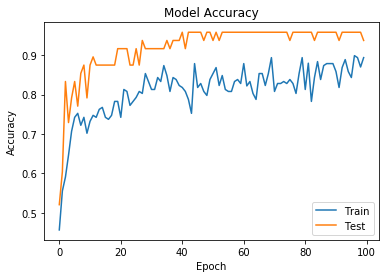

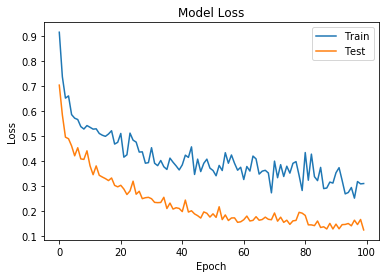

In [27]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig('vgg_model_accuracy_DataGenerator.jpeg')
plt.savefig('vgg_model_accuracy_DataGenerator.svg')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig('vgg_model_loss_DataGenerator.jpeg')
plt.savefig('vgg_model_loss_DataGenerator.svg')
plt.show()

### Evaluation

In [28]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.96      0.93      0.95        28
      normal       0.93      0.96      0.94        26

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
pred = model.predict(trainX)
precisions,recalls,thresholds = precision_recall_curve(np.argmax(trainY,axis=1),np.argmax(pred,axis=1))
fpr,tpr,thresholds2 = roc_curve(np.argmax(trainY,axis=1),np.argmax(pred,axis=1))
def plot_precision_recall(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--')
    plt.plot(thresholds,recalls[:-1],'g-')
    plt.title("Precision Vs Recall")
    plt.xlabel('Thresholds')
    plt.legend(['Precision','Recall'],loc='best')
    
    plt.savefig("VGG16_precision_recall.svg")
    plt.savefig("VGG16_precision_recall.jpeg")
    plt.show()
    
def plot_rcc(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.title('FPR Vs TPR')
#     FPR = False Positive Rate and TPR = True Positive Rate
    plt.xlabel("FPR")
    plt.ylabel("TPR(RECALL)")
    plt.legend(['FPR','TPR'],loc='best')
    plt.savefig("ROC_VGG16.svg")
    plt.savefig("ROC_VGG16.jpeg")
    plt.show()
    
plot_precision_recall(precisions,recalls,thresholds)
plot_rcc(fpr,tpr)

#### Confusion matrix

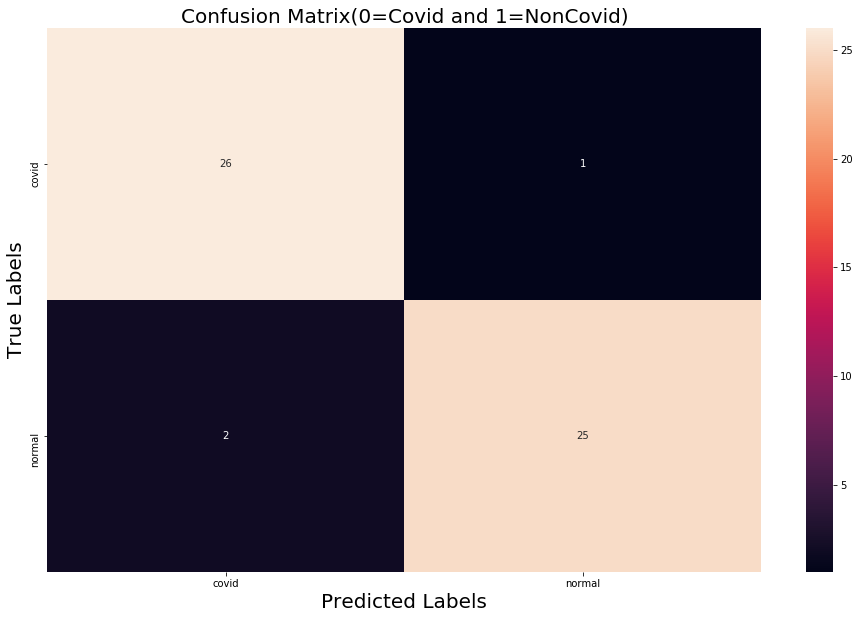

In [29]:
import seaborn as sns 
# plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)
ax.xaxis.set_ticklabels(lb.classes_)
ax.yaxis.set_ticklabels(lb.classes_)
plt.savefig("Vgg16_CHest_CM_DataGenerator.jpeg")
plt.savefig("Vgg16_CHest_CM_DataGenerator.svg")
plt.show()
# ax.xaxis.set_ticklabels(labels)
# ax.yaxis.set_ticklabels(labels)

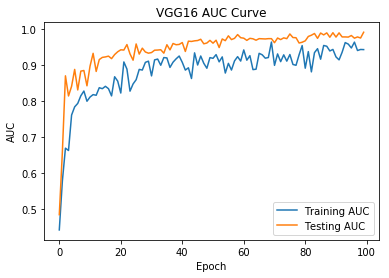

In [30]:
plt.plot(vgg_history.history['auc'])
plt.plot(vgg_history.history['val_auc'])
plt.title("VGG16 AUC Curve")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(['Training AUC','Testing AUC'],loc='lower right')
plt.savefig("Vgg_AUC_DataGenerator.svg")
plt.savefig("Vgg_AUC.jpeg")
plt.show()

In [ ]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(40):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

In [ ]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(6,9,1):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.savefig('vgg_model_test_imgae.svg')
plt.show()

# AUC PRECISION RECALL curve

In [ ]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(15,10))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(vgg_history)

In [ ]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(15,10))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.savefig(f'vgg_{metric}.svg')
        plt.legend()
plot_metrics(vgg_history)

# Foolbox Adversarial Attack

In [31]:
pip install foolbox==1.3.2

     |████████████████████████████████| 226 kB 4.4 MB/s eta 0:00:01
  Created wheel for foolbox: filename=foolbox-1.3.2-py3-none-any.whl size=243121 sha256=e5f275c22e70152c859774c032cbf92de49ee992fc57c4a4fb4314fcf5642a67
  Stored in directory: /root/.cache/pip/wheels/4f/e5/da/174670a1a2d2e1db7763417a7621b153abbd8d1b4634fee2b6
Successfully built foolbox
Note: you may need to restart the kernel to use updated packages.


In [32]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import FGSM
from foolbox.criteria import TargetClassProbability

In [33]:
attack_model = KerasModel(model,bounds=(0,255))
attack = FGSM(attack_model)

Using TensorFlow backend.


In [34]:
label=['covid','normal']

In [ ]:
#trying to find the gradient and see if the covid works
i=9
image = testX[i]
# print(label[np.argmax(model.predict(testX[1].reshape(1,224,224,3)))])
image_grad = attack_model.gradient(image,np.argmax(testY[i]))
# print(np.argmax(testY[1]))
adversarial_image = image + image_grad * 652
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(adversarial_image.reshape(1,224,224,3)))])
plt.imshow(image.reshape(224,224,3))


In [ ]:
plt.imshow(adversarial_image.reshape(224,224,3))

In [ ]:
k=1

In [ ]:
attack_image = attack(testX[k],(np.argmax(testY[k])))
print(label[np.argmax(model.predict(testX[k].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])



In [ ]:
# attack_model2 = KerasModel(model,bounds=(0,255))
# attack2 = FGSM(attack_model2)
i=0
attack_image = attack(testX[i],(np.argmax(testY[i])))
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])
i=1
attack_image = attack(testX[i],(np.argmax(testY[i])))
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])
i=2
attack_image = attack(testX[i],(np.argmax(testY[i])))
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])

In [ ]:
dict = {}
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        key = i
        value = np.argmax(model.predict(attack_image.reshape(1,224,224,3)))
        dict.update({key:value})
    
    

In [ ]:
dict

In [ ]:
for k, v in dict.items():
    print (k, v)

In [ ]:
for k, v in dict.items():
    print (k, np.argmax(testY[k]))

# Find Accuracy

In [ ]:
count_same =0
for k, v in dict.items():
    if(v==np.argmax(testY[k])):
        count_same=count_same + 1
        
print("Number of right Predictions : ",count_same)

if(count_same==0):
    print("Total Accuracy : Nil")
else:
    accuracy = (count_same/len(test(dict))) * 100
    
#     print(v,np.argmax(testY[k]))
#     print (k, np.argmax(testY[k]))

# ** *Above result proves that the training model can be 100% fooled. However five images can not be parsed due to gradient issue.***

## Here i try to work with gradient and episilon to handle the perturbations manually

In [ ]:
predIdxs,predIdxs[0],predIdxs[1]

In [ ]:
import tensorflow as tf
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label,prediction):
    
      with tf.GradientTape() as tape:
        tape.watch(input_image)
#         prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
      gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
      signed_grad = tf.sign(gradient)
      return signed_grad

In [ ]:
grad = attack_model.gradient(testX[1],np.argmax(testY[1]))
print(grad)

In [ ]:
signed_grad = tf.sign(grad)
print(signed_grad)

In [ ]:
plt.imshow(signed_grad)

In [ ]:
adversarial_image = testX[1]+(signed_grad*0.002)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[1].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=47
eps=0.005
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])


In [ ]:

fig = plt.figure(figsize =(40,40))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(testX[i].reshape(224,224,3))
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(signed_grad)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(adv_image.reshape(224,224,3))

In [ ]:
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [35]:
import tensorflow as tf

covid
normal


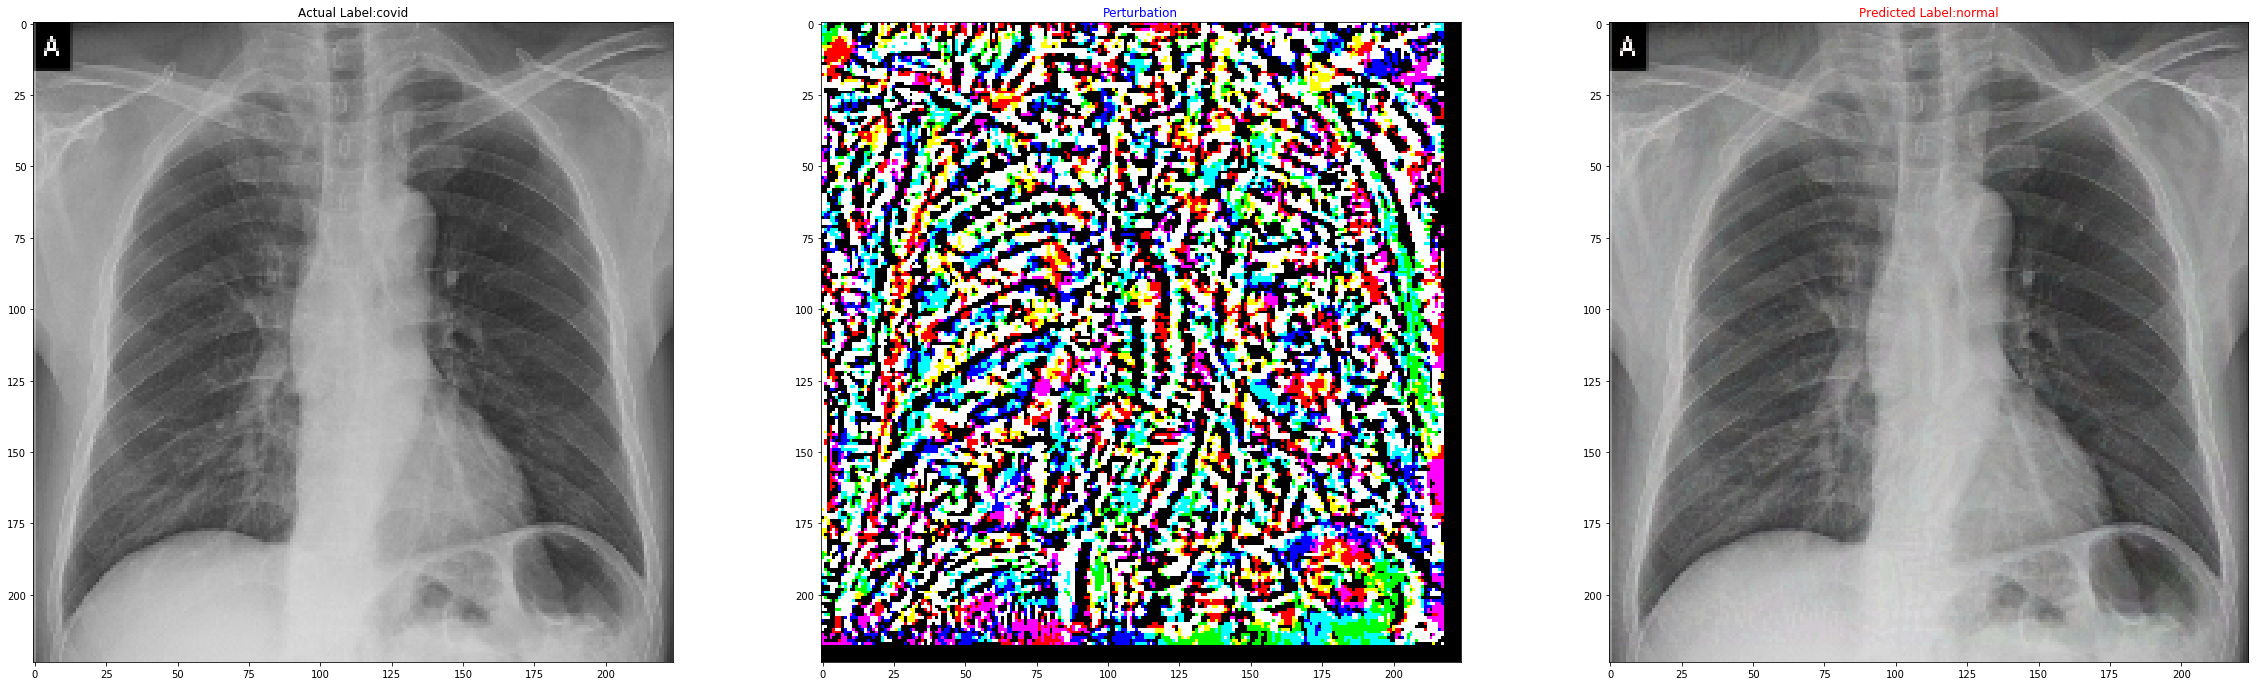

In [38]:
i=3
eps=0.009
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred=label[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))]
print(org_label)
print(adv_pred)
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred),color='red')
plt.imshow(adv_image.reshape(224,224,3))
# plt.savefig("vgg_adversarial_attack_id0.svg")
plt.plot()
plt.savefig("vgg_adversarial_attack_id0.svg")

In [ ]:
i=42
eps=0.009
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred=labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))]

print(org_label)
print(adv_pred)
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred),color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
model.predict(adv_image.reshape(1,224,224,3))

In [ ]:
i=42
eps=0
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred=labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))]

print(org_label)
print(adv_pred)
print(model.predict(adv_image.reshape(1,224,224,3)))
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred),color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=0
eps=0.08
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred=labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))]

print(org_label)
print(adv_pred)
print(model.predict(adv_image.reshape(1,224,224,3)))
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred),color='red')
plt.imshow(adv_image.reshape(224,224,3))
plt.savefig("vgg_adversarial_attack_id0_withProbability.svg")

In [ ]:
i=0
eps=0.08
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
print(model.predict(adv_image.reshape(1,224,224,3)))
print(max(max(model.predict(adv_image.reshape(1,224,224,3)))))
print(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

normal
covid


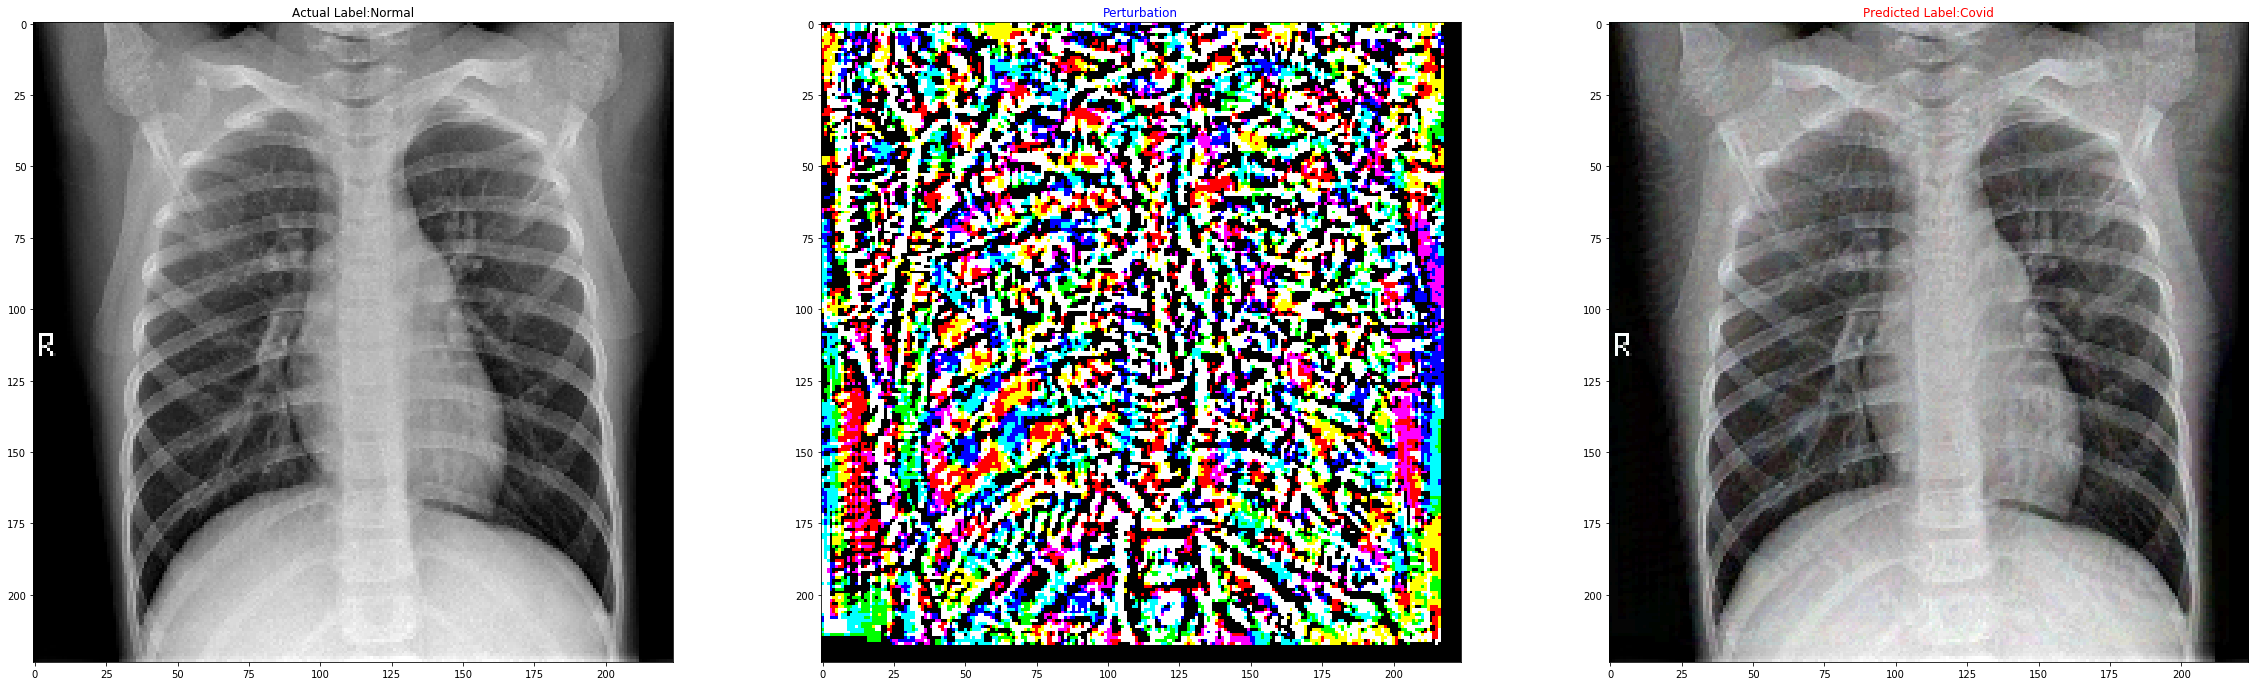

In [39]:
i=0
eps=.02
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

# Generate all statictis

In [40]:
import tensorflow as tf
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09]
# epsilon=[0.0003]
for eps in epsilon:
    probability=[]
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_prob = max(max(model.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability.append(max_prob)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    try:
        prob_decrease = (sum(probability)/len(probability))*100
    except:
        prob_decrease =0
    final_probability.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,prob_decrease))
    

For epsilon : 0.0001
Numbers of Correct Prediction with Adversarial :  51
Numbers of Wrong Prediction with Adversarial :  3
Accuracy during eps = 0.0001 is 94.4444
Probability of total images = 51 during eps = 0.0001 is 94.7650
For epsilon : 0.0003
Numbers of Correct Prediction with Adversarial :  51
Numbers of Wrong Prediction with Adversarial :  3
Accuracy during eps = 0.0003 is 94.4444
Probability of total images = 51 during eps = 0.0003 is 93.3078
For epsilon : 0.0005
Numbers of Correct Prediction with Adversarial :  49
Numbers of Wrong Prediction with Adversarial :  5
Accuracy during eps = 0.0005 is 90.7407
Probability of total images = 49 during eps = 0.0005 is 93.3959
For epsilon : 0.0007
Numbers of Correct Prediction with Adversarial :  48
Numbers of Wrong Prediction with Adversarial :  6
Accuracy during eps = 0.0007 is 88.8889
Probability of total images = 48 during eps = 0.0007 is 92.5760
For epsilon : 0.0009
Numbers of Correct Prediction with Adversarial :  47
Numbers of Wro

In [41]:
data_list = {'Epsilon':worked_eps,'Correct Predict':correct_pred,'Wrong Predict':wrong_pred,'Accuracy':accuracy_correct_pred_on_that_eps,'Probability Decrease':final_probability}
adversarial_dataframe_sars= pd.DataFrame(data_list)
adversarial_dataframe_sars.to_excel(r'../working/chest_vgg16_ImageGenerator_withPredictionDecrease.xlsx', sheet_name='ChestXray Dense201', index = False)


In [ ]:
#now try to get altogether
epsilon =0.006
count_adv=0
vhul_count_adv=0
for k, v in dict.items():
    grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
        

In [ ]:
#now try to get altogether
epsilon =1
count_adv=0
vhul_count_adv=0
for k, v in dict.items():
    grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)

In [ ]:
#for total image set in test
#now try to get altogether
epsilon =0.009
count_adv=0
vhul_count_adv=0
for k in range(len(testX)):
    grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Id={} Prediction Milse : {} == {}".format(k,labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Id={} Prediction Mile Nai : {} == {}".format(k,labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
        

In [ ]:
import tensorflow as tf
# epsilon=[0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
#          0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
#          0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
#          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
    
# ]
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.002,0.004,0.006,0.008,]
for eps in epsilon:
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {}".format(eps,acc))

In [ ]:
#prediction probability
import tensorflow as tf
# epsilon=[0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
#          0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
#          0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
#          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
    
# ]
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.002,0.004,0.006,0.008,]
# epsilon=[0.0003]
for eps in epsilon:
    probability=[]
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_prob = max(max(model.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability.append(max_prob)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    prob_decrease = (sum(probability)/len(probability))*100
    final_probability.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,prob_decrease))
    

In [ ]:
epsilon

In [ ]:
correct_pred

In [ ]:
wrong_pred

In [ ]:
accuracy_correct_pred_on_that_eps

In [ ]:
final_probability

In [ ]:
data_list = {'Epsilon':worked_eps,'Correct Predict':correct_pred,'Wrong Predict':wrong_pred,'Accuracy':accuracy_correct_pred_on_that_eps,'Probability Decrease':final_probability}
adversarial_dataframe_sars= pd.DataFrame(data_list)
adversarial_dataframe_sars.to_excel(r'../working/ct_vgg16_withPredictionDecrease.xlsx', sheet_name='ChestXray Vgg16', index = False)


## End of Manually Worked

In [ ]:
count_same =0
len(dict)

In [ ]:
attack_image = attack(testX[2],(np.argmax(testY[2])))
np.argmax(model.predict(attack_image.reshape(1,224,224,3)))
print(label[np.argmax(model.predict(testX[2].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])

In [ ]:
if(attack_image is not None):
    print("yes")
else:
    print("no")

In [ ]:
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        print(i)
    

In [ ]:
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        print(i)
    

In [ ]:
final ={}
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        print(i)
    
    

In [ ]:
attack_image = attack(testX[5],(np.argmax(testY[5],axis=0)))

In [ ]:
attack_image_adv = attack(adv_testX[5],(np.argmax(adv_testY[5],axis=0)))

In [ ]:
adv_trainX=trainX
adv_testX=testX
adv_trainY=trainY
adv_testY=testY

In [ ]:
print(attack_image_adv)

In [ ]:
print(attack_image)

In [ ]:
print(labels[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(attack_image_adv.reshape(1,224,224,3)))])

In [ ]:
attack = FGSM(attack_model)
attack_image_adv1 = attack(testX[1],(np.argmax(testY[1],axis=0)))
print(attack_image_adv1)

In [ ]:
labels=['covid','normal']

In [ ]:
attack = FGSM(attack_model)
attack_image_adv1 = attack(testX[1],(np.argmax(testY[1],axis=0)))
attack1 = FGSM(attack_model)
attack_image_adv2 = attack1(testX[2],(np.argmax(testY[2],axis=0)))
print(labels[np.argmax(model.predict(testX[1].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(testX[2].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(attack_image_adv1.reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(attack_image_adv2.reshape(1,224,224,3)))])

In [ ]:
image_adver = attack_image

In [ ]:
plt.imshow(image_adver.reshape(224,224,3))

In [ ]:
plt.imshow(testX[2])

In [ ]:
image_adver.shape,attack_image.shape

In [ ]:
labels[np.argmax(model.predict(testX[2].reshape(1,224,224,3)))]

In [ ]:
labels[np.argmax(model.predict(image_adver.reshape(1,224,224,3)))]

In [ ]:
i=3
attack_image = attack(testX[3],(np.argmax(testY[3],axis=0)))
print(attack_image)
attack_image_adv = attack(adv_testX[3],(np.argmax(adv_testY[3],axis=0)))
print(attack_image_adv)

In [ ]:
image_adver = attack_image
image_adver.shape , attack_image.shape

In [ ]:
labels[np.argmax(model.predict(testX[5].reshape(1,224,224,3)))]

In [ ]:
np.argmax(model.predict(image_adver.reshape(1,224,224,3)))

In [ ]:
labels[np.argmax(model.predict(image_adver.reshape(1,224,224,3)))]

In [ ]:
np.argmax(testY[1])

In [ ]:
attack_vhul = attack(testX[8],(np.argmax(testY[8],axis=0)))

In [ ]:
attack_image = attack(adv_testX[3],(np.argmax(adv_testY[3])))
image_adversarial = attack_image
np.argmax(model.predict(image_adversarial.reshape(1,224,224,3)))

In [ ]:
#try first 5 images
adv_pred = []
for i in range(5):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    image_adversarial = attack_image
    pred = np.argmax(model.predict(image_adversarial.reshape(1,224,224,3)))
    adv_pred.append(pred)
    

***new try above***

In [ ]:
adv_model = KerasModel(model,bounds=(0,255))

In [ ]:
attack_FGSM = FGSM(model=adv_model)

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
i=10

In [ ]:
# testY[i]
pred_fgsm = []
pred_mod =[]

In [ ]:
j=12
advexp = attack_FGSM(testX[5],np.argmax(testY[5]))
pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))

In [ ]:
pred_fgsm

In [ ]:
print(labels[np.argmax(testY[5],axis=0)])

In [ ]:
for j in range(20):
#     print(labels[np.argmax(testY[i],axis=0)])
    advexp = attack_FGSM(testX[j],np.argmax(testY[j]))
    pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))

In [ ]:
pred_fgsm

In [ ]:
# attack_FGSM = FGSM(model=adv_model)


# print(labels[np.argmax(testY[i],axis=0)])
# i=4
# advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
# print(advexp)
# adversarial = attack_FGSM(testX[i],np.argmax(testY[i],axis=0))
# advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
# print(advexp)
# print(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
# np.argmax(model.predict(advexp.reshape(1,224,224,3)))
# pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
# for j in range(20):
# #     testY[i]
#     print(labels[np.argmax(testY[j],axis=0)])
#     advexp = attack_FGSM(testX[j],np.argmax(testY[j]))
#     pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
j=12
print(labels[np.argmax(testY[i],axis=0)])
advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
    

In [ ]:
labels[0],labels[1]

In [ ]:
print(labels[np.argmax(testY[i],axis=0)])
np.argmax(testY[i],axis=0)

In [ ]:
np.argmax(testY[i],axis=0)

In [ ]:
advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
print(advexp)

In [ ]:
np.argmax(model.predict(testX[i].reshape(1,224,224,3)))

In [ ]:
np.argmax(adv_model.predictions(advexp))

In [ ]:
#try to predict adv image with original model
np.argmax(model.predict(advexp.reshape(1,224,224,3)))

In [ ]:
#here i checked the output image and title of original model
plt.imshow(testX[1].reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])


In [ ]:
#here i checked the adversarial image and title with original model
plt.imshow(testX[i].reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(advexp.reshape(1,224,224,3)))])

In [ ]:
#here i checked the output image and title of adversarial model
plt.imshow(advexp.reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(adv_model.predictions(advexp))])

In [ ]:
np.argmax(adv_model.predictions(advexp))

In [ ]:
#try to find the gradient of the original image
org_grad = adv_model.gradient(testX[i],np.argmax(testY[i],axis=0))


In [ ]:
org_image = testX[i]
plt.imshow(org_image)

In [ ]:
new_image_after_add_grad = org_image+np.multiply(org_grad,0.99)
plt.imshow(new_image_after_add_grad)

In [ ]:
#prediction of image after adding grad with original image
plt.imshow(testX[i].reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(new_image_after_add_grad.reshape(1,224,224,3)))])

In [ ]:
#here i add test image with fgsm attacked gradient and then put into our original model to predict the new image
new_image  = testX[i]+advexp*0.99
plt.imshow(new_image.reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(new_image.reshape(1,224,224,3)))])

In [ ]:
plt.imshow(new_image.reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(adv_model.predictions(new_image))])

In [ ]:
plt.imshow(new_image)

In [ ]:
plt.imshow(advexp)

In [ ]:
plt.imshow(new_image_after_add_grad.reshape(224,224,3))

In [ ]:
model.evaluate(testX,testY)

# Try to implement for sars

In [ ]:
dataset_path = './dataset2'

In [ ]:
%%bash
rm -rf dataset2
mkdir -p dataset2/Sars
mkdir -p dataset2/Normal

In [ ]:
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "SARS":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/Sars", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [ ]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
# print("ImagePath {}\n".format(imagePaths))



# randomly sample the image paths
random.seed(random_value) #47
random.shuffle(imagePaths)
imagePaths = imagePaths[:25] 
"""
[:@]
If @ is following -
#70 and 50 is good
#35 and 25(as given) is better(and same)
"""
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/Normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [ ]:
path, dirs, files1 = next(os.walk("../working/dataset2/Sars/"))
print(len(files1))
path, dirs, files2 = next(os.walk("../working/dataset2/Normal/"))
print(len(files2))

print(len(files1)+len(files2))

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(len(paths.list_images(dataset_path)))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [ ]:
y_train = trainY.tolist()
print("Total data in train set : ",len(y_train))

sars=0
nonsars=0

for idx,i in enumerate(y_train):
    if(i == [1.0, 0.0]):
        sars+=1
    else:
        nonsars+=1
print("In distribution of train Sars = {} and Normal = {}".format(sars,nonsars))

y_test = testY.tolist()
print("Total data in test set : ",len(y_test))
sars=0
nonsars=0

for idx,i in enumerate(y_test):
    if(i == [1.0, 0.0]):
        sars+=1
    else:
        nonsars+=1
print("In distribution of test Sars = {} and Normal = {}".format(sars,nonsars))

In [ ]:
print("[INFO] compiling model...")
BS=1
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=METRICS)
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='Vgg16_best_till_now.h5',monitor='val_loss',save_best_only=True)
            ]

# train the head of the network
print("[INFO] training head...")
vgg_history = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

In [ ]:
import seaborn as sns 
plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix',size=20)

# ax.xaxis.set_ticklabels(labels)
# ax.yaxis.set_ticklabels(labels)

In [ ]:
labels=['Sars','Normal']
plt.figure(figsize =(40,40))
for i in range(len(testX)):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

In [ ]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(15,10))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(vgg_history)

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Foolbox attack on SARS

In [ ]:
attack_model_sars = KerasModel(model,bounds=(0,255))
attack_sars = FGSM(attack_model_sars)

In [ ]:
i=2
eps=0.02
grad = attack_model_sars.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred_label=labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))]
print(org_label)
print(adv_pred_label)

In [ ]:
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred_label),color='red')
plt.imshow(adv_image.reshape(224,224,3))

# Inception V3 Model

In [42]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = 224
pre_trained_model = InceptionV3(
  input_shape = (image_size, image_size, 3),
  include_top = False,
  weights = 'imagenet')

for layer in pre_trained_model.layers:
    
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87916544/87910968 [==============================] - 1s 0us/step
last layer output shape:  (None, 12, 12, 768)


In [43]:
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

v3_model = Model(pre_trained_model.input, x)

In [44]:
v3_model.compile(
  optimizer = Adam(lr=INIT_LR), 
  loss = 'binary_crossentropy', 
  metrics = METRICS)

In [47]:
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='InceptionV3_best_till_now.h5',monitor='val_loss',save_best_only=True)
    
]
incept_history = v3_model.fit(
  trainAug.flow(trainX, trainY, batch_size=BS,save_to_dir="../working/dataset/generated_two/"),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
# callbacks=callbacks
)

Train for 13 steps, validate on 54 samples
Epoch 1/100
13/13 [==============================] - 11s 852ms/step - loss: 3.5634 - accuracy: 0.6540 - tp: 129.0000 - fp: 68.0000 - tn: 130.0000 - fn: 69.0000 - precision: 0.6548 - recall: 0.6515 - auc: 0.6752 - val_loss: 0.9578 - val_accuracy: 0.7812 - val_tp: 48.0000 - val_fp: 21.0000 - val_tn: 27.0000 - val_fn: 0.0000e+00 - val_precision: 0.6957 - val_recall: 1.0000 - val_auc: 0.9067
Epoch 2/100
13/13 [==============================] - 4s 338ms/step - loss: 1.8563 - accuracy: 0.7399 - tp: 145.0000 - fp: 50.0000 - tn: 148.0000 - fn: 53.0000 - precision: 0.7436 - recall: 0.7323 - auc: 0.7878 - val_loss: 0.4115 - val_accuracy: 0.8854 - val_tp: 48.0000 - val_fp: 11.0000 - val_tn: 37.0000 - val_fn: 0.0000e+00 - val_precision: 0.8136 - val_recall: 1.0000 - val_auc: 0.9655
Epoch 3/100
13/13 [==============================] - 5s 372ms/step - loss: 1.2811 - accuracy: 0.8131 - tp: 163.0000 - fp: 39.0000 - tn: 159.0000 - fn: 35.0000 - precision: 0.80

13/13 [==============================] - 5s 396ms/step - loss: 0.2937 - accuracy: 0.8889 - tp: 176.0000 - fp: 22.0000 - tn: 176.0000 - fn: 22.0000 - precision: 0.8889 - recall: 0.8889 - auc: 0.9504 - val_loss: 0.1234 - val_accuracy: 0.9167 - val_tp: 43.0000 - val_fp: 3.0000 - val_tn: 45.0000 - val_fn: 5.0000 - val_precision: 0.9348 - val_recall: 0.8958 - val_auc: 0.9883
Epoch 23/100
13/13 [==============================] - 5s 376ms/step - loss: 0.1812 - accuracy: 0.9242 - tp: 185.0000 - fp: 17.0000 - tn: 181.0000 - fn: 13.0000 - precision: 0.9158 - recall: 0.9343 - auc: 0.9812 - val_loss: 0.1029 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9848
Epoch 24/100
13/13 [==============================] - 5s 355ms/step - loss: 0.1567 - accuracy: 0.9419 - tp: 187.0000 - fp: 12.0000 - tn: 186.0000 - fn: 11.0000 - precision: 0.9397 - recall: 0.9444 - auc: 0.9875 - val_loss: 0.1183 - val_accur

13/13 [==============================] - 5s 368ms/step - loss: 0.1722 - accuracy: 0.9343 - tp: 184.0000 - fp: 12.0000 - tn: 186.0000 - fn: 14.0000 - precision: 0.9388 - recall: 0.9293 - auc: 0.9812 - val_loss: 0.1238 - val_accuracy: 0.9479 - val_tp: 45.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 3.0000 - val_precision: 0.9574 - val_recall: 0.9375 - val_auc: 0.9889
Epoch 44/100
13/13 [==============================] - 5s 356ms/step - loss: 0.1374 - accuracy: 0.9394 - tp: 186.0000 - fp: 12.0000 - tn: 186.0000 - fn: 12.0000 - precision: 0.9394 - recall: 0.9394 - auc: 0.9896 - val_loss: 0.1426 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9750
Epoch 45/100
13/13 [==============================] - 5s 363ms/step - loss: 0.2289 - accuracy: 0.9015 - tp: 179.0000 - fp: 20.0000 - tn: 178.0000 - fn: 19.0000 - precision: 0.8995 - recall: 0.9040 - auc: 0.9699 - val_loss: 0.1436 - val_accur

13/13 [==============================] - 5s 377ms/step - loss: 0.1741 - accuracy: 0.9279 - tp: 193.0000 - fp: 15.0000 - tn: 193.0000 - fn: 15.0000 - precision: 0.9279 - recall: 0.9279 - auc: 0.9830 - val_loss: 0.2047 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9757
Epoch 65/100
13/13 [==============================] - 4s 336ms/step - loss: 0.2772 - accuracy: 0.9066 - tp: 181.0000 - fp: 20.0000 - tn: 178.0000 - fn: 17.0000 - precision: 0.9005 - recall: 0.9141 - auc: 0.9710 - val_loss: 0.1696 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9744
Epoch 66/100
13/13 [==============================] - 5s 377ms/step - loss: 0.1727 - accuracy: 0.9444 - tp: 186.0000 - fp: 10.0000 - tn: 188.0000 - fn: 12.0000 - precision: 0.9490 - recall: 0.9394 - auc: 0.9812 - val_loss: 0.1359 - val_accur

13/13 [==============================] - 5s 358ms/step - loss: 0.1130 - accuracy: 0.9520 - tp: 187.0000 - fp: 8.0000 - tn: 190.0000 - fn: 11.0000 - precision: 0.9590 - recall: 0.9444 - auc: 0.9926 - val_loss: 0.1358 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9768
Epoch 86/100
13/13 [==============================] - 5s 370ms/step - loss: 0.1226 - accuracy: 0.9318 - tp: 185.0000 - fp: 14.0000 - tn: 184.0000 - fn: 13.0000 - precision: 0.9296 - recall: 0.9343 - auc: 0.9916 - val_loss: 0.1328 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9774
Epoch 87/100
13/13 [==============================] - 5s 381ms/step - loss: 0.1244 - accuracy: 0.9394 - tp: 186.0000 - fp: 12.0000 - tn: 186.0000 - fn: 12.0000 - precision: 0.9394 - recall: 0.9394 - auc: 0.9903 - val_loss: 0.1277 - val_accura

In [48]:
import glob
count=0
for i in glob.glob("../working/dataset/generated_two/*"):
    count+=1
print(count)

21294


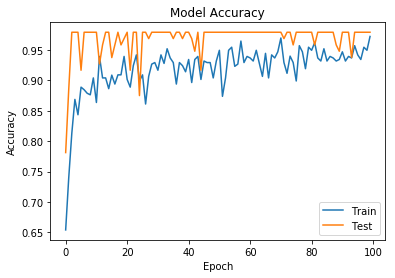

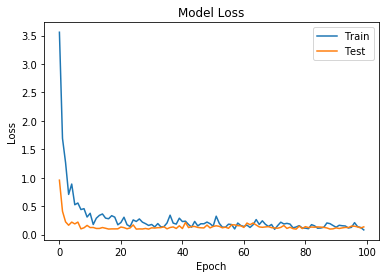

In [49]:
plt.plot(incept_history.history['accuracy'])
plt.plot(incept_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("~Inception_acc.jpeg")
plt.show()

plt.plot(incept_history.history['loss'])
plt.plot(incept_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("~Inception_loss.jpeg")
plt.show()

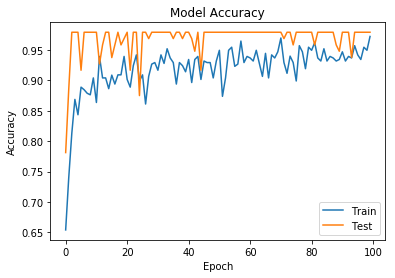

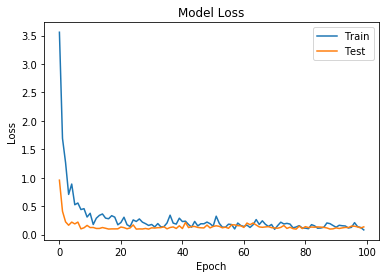

In [50]:
plt.plot(incept_history.history['accuracy'])
plt.plot(incept_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("~InceptionV3_accuracy.svg")
plt.show()

plt.plot(incept_history.history['loss'])
plt.plot(incept_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("~InceptionV3_loss.svg")
plt.show()

In [51]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = v3_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))



[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.97      1.00      0.98        28
      normal       1.00      0.96      0.98        26

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
pred = v3_model.predict(trainX)
precisions,recalls,thresholds = precision_recall_curve(np.argmax(trainY,axis=1),np.argmax(pred,axis=1))
fpr,tpr,thresholds2 = roc_curve(np.argmax(trainY,axis=1),np.argmax(pred,axis=1))
def plot_precision_recall(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--')
    plt.plot(thresholds,recalls[:-1],'g-')
    plt.title("Precision Vs Recall")
    plt.xlabel('Thresholds')
    plt.legend(['Precision','Recall'],loc='best')
    
    plt.savefig("VGG16_precision_recall.svg")
    plt.savefig("VGG16_precision_recall.jpeg")
    plt.show()
    
def plot_rcc(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.title('FPR Vs TPR')
#     FPR = False Positive Rate and TPR = True Positive Rate
    plt.xlabel("FPR")
    plt.ylabel("TPR(RECALL)")
    plt.legend(['FPR','TPR'],loc='best')
    plt.savefig("ROC_Inception.jpeg")
#     plt.savefig("ROC_VGG16.jpeg")
    plt.show()
    
plot_precision_recall(precisions,recalls,thresholds)
plot_rcc(fpr,tpr)

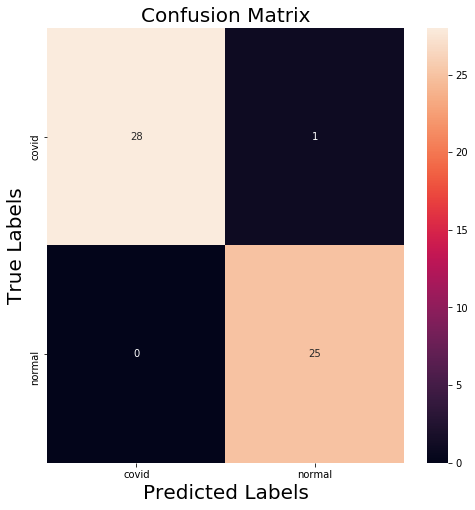

In [52]:
import seaborn as sns 
# plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(8,8))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix',size=20)
ax.xaxis.set_ticklabels(lb.classes_)
ax.yaxis.set_ticklabels(lb.classes_)
plt.savefig("~Inception_CHest_CM.jpeg")
plt.savefig("~Inception_CHest_CM.svg")
plt.show()

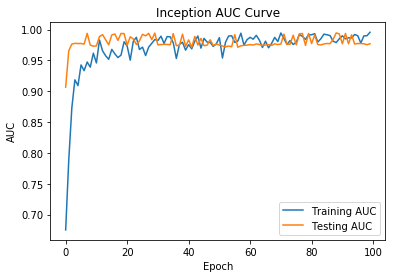

In [53]:
plt.plot(incept_history.history['auc'])
plt.plot(incept_history.history['val_auc'])
plt.title("Inception AUC Curve")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(['Training AUC','Testing AUC'],loc='lower right')
plt.savefig("~Inception_AUC.jpeg")
plt.savefig("~Inception_AUC.jpeg")
plt.show()

In [ ]:
# model.save_weights("inceptionv3_weights_at_random_state_{}.h5".format(random_value))

In [ ]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(8,11,1):
    plt.subplot(7,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.savefig("Inception_testImage.svg")
plt.show()

In [ ]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(40):
    plt.subplot(7,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

In [ ]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(20,15))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(incept_history)

In [54]:
attack_model_incpt = KerasModel(v3_model,bounds=(0,255))
attack_incpt = FGSM(attack_model_incpt)

In [55]:
#prediction probability
import tensorflow as tf

worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09]
# epsilon=[0.0003]
for eps in epsilon:
    probability=[]
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model_incpt.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_prob = max(max(v3_model.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability.append(max_prob)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    try:
        prob_decrease = (sum(probability)/len(probability))*100
    except:
        prob_decrease =0
    final_probability.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,prob_decrease))
    

For epsilon : 0.0001
Numbers of Correct Prediction with Adversarial :  53
Numbers of Wrong Prediction with Adversarial :  1
Accuracy during eps = 0.0001 is 98.1481
Probability of total images = 53 during eps = 0.0001 is 98.7202
For epsilon : 0.0003
Numbers of Correct Prediction with Adversarial :  51
Numbers of Wrong Prediction with Adversarial :  3
Accuracy during eps = 0.0003 is 94.4444
Probability of total images = 51 during eps = 0.0003 is 98.2175
For epsilon : 0.0005
Numbers of Correct Prediction with Adversarial :  51
Numbers of Wrong Prediction with Adversarial :  3
Accuracy during eps = 0.0005 is 94.4444
Probability of total images = 51 during eps = 0.0005 is 94.2418
For epsilon : 0.0007
Numbers of Correct Prediction with Adversarial :  46
Numbers of Wrong Prediction with Adversarial :  8
Accuracy during eps = 0.0007 is 85.1852
Probability of total images = 46 during eps = 0.0007 is 92.2180
For epsilon : 0.0009
Numbers of Correct Prediction with Adversarial :  41
Numbers of Wro

In [56]:
data_list = {'Epsilon':worked_eps,'Correct Predict':correct_pred,'Wrong Predict':wrong_pred,'Accuracy':accuracy_correct_pred_on_that_eps,'Probability Decrease':final_probability}
adversarial_dataframe_sars= pd.DataFrame(data_list)
adversarial_dataframe_sars.to_excel(r'../working/chest_InceptionV3_imageGenerator_withPredictionDecrease.xlsx', sheet_name='ChestXray InceptionV3', index = False)


In [ ]:
i=0
eps=0.009
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred=labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))]
print(org_label)
print(adv_pred)
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred),color='red')
plt.imshow(adv_image.reshape(224,224,3))
# plt.savefig("vgg_adversarial_attack_id0.svg")
plt.plot()
# plt.savefig("vgg_adversarial_attack_id0.svg")

In [ ]:
#prediction probability
import tensorflow as tf
# epsilon=[0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
#          0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
#          0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
#          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
    
# ]
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.002,0.004,0.006,0.008,]
# epsilon=[0.0003]
for eps in epsilon:
    probability=[]
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model_incpt.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_prob = max(max(v3_model.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability.append(max_prob)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    prob_decrease = (sum(probability)/len(probability))*100
    final_probability.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,prob_decrease))
    

In [ ]:
data_list = {'Epsilon':worked_eps,'Correct Predict':correct_pred,'Wrong Predict':wrong_pred,'Accuracy':accuracy_correct_pred_on_that_eps,'Probability Decrease':final_probability}
adversarial_dataframe_sars= pd.DataFrame(data_list)
adversarial_dataframe_sars.to_excel(r'../working/ct_InceptionV3_withPredictionDecrease.xlsx', sheet_name='ChestXray InceptionV3', index = False)


In [ ]:
#prediction probability
import tensorflow as tf
# epsilon=[0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
#          0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
#          0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
#          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
    
# ]
worked_eps2=[]
correct_pred2=[]
wrong_pred2=[]
accuracy_correct_pred_on_that_eps2=[]
total_n2 = len(testX)
final_probability2=[]
epsilon2=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.002,0.004,0.006,0.008,]
# epsilon=[0.0003]
for eps in epsilon2:
    probability2=[]
    count_adv2=0
    vhul_count_adv2=0
    for k in range(total_n2):
        grad = attack_model_incpt.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv2=count_adv2+1
            max_prob2 = max(max(v3_model.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability2.append(max_prob2)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv2=vhul_count_adv2+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps2.append(eps)
    correct_pred2.append(count_adv2)
    wrong_pred2.append(vhul_count_adv2)
    acc = (count_adv2/total_n2)*100
    accuracy_correct_pred_on_that_eps2.append(acc)
    prob_decrease = (sum(probability2)/len(probability2))*100
    final_probability2.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv2)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv2)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.4f}".format(len(probability2),eps,prob_decrease))
    

In [ ]:
dict_incpt = {}
for i in range(len(testX)):
    attack_image = attack_incpt(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        key = i
        value = np.argmax(v3_model.predict(attack_image.reshape(1,224,224,3)))
        dict_incpt.update({key:value})
    

In [ ]:
dict_incpt

In [ ]:
count_same =0
for k, v in dict_incpt.items():
    if(v==np.argmax(testY[k])):
        count_same=count_same + 1
        
print("Number of right Predictions : ",count_same)

if(count_same==0):
    print("Total Accuracy : Nil")
else:
    accuracy = (count_same/len(test(dict))) * 100

In [ ]:
i=31
eps=0.007
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
print(signed_grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])


In [ ]:

fig = plt.figure(figsize =(40,40))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(testX[i].reshape(224,224,3))
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(signed_grad)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(adv_image.reshape(224,224,3))

In [ ]:
#for total image set in test
#now try to get altogether
epsilon =0
count_adv=0
vhul_count_adv=0
for k in range(len(testX)):
    grad = attack_model_incpt.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)

In [ ]:
import tensorflow as tf

In [ ]:
i=33
eps=.0001
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tensorflow.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label =label[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred = label[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))]
print(org_label)
print(adv_pred)
print(v3_model.predict(adv_image.reshape(1,224,224,3)))
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred),color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
#for total image set in test
#now try to get altogether
import tensorflow as tf
label=['covid','normal']
epsilon =0.009
count_adv=0
vhul_count_adv=0
for k in range(len(testX)):
    grad = attack_model_incpt.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Id={} Prediction Milse : {} == {}".format(k,label[orginal_pred],label[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Id={} Prediction Mile Nai : {} == {}".format(k,label[orginal_pred],label[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
        

In [ ]:
i=13
eps=.08
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tensorflow.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=0
eps=.02
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=53
eps=.002
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

# implementing foolbox on inception

In [ ]:
pip install foolbox==2.4.0

In [ ]:
import foolbox
# from foolbox.models import TensorFlowModel
from foolbox.attacks import FGSM
# from foolbox.criteria import TargetClassProbability

In [ ]:
import foolbox
foolbox.__version__

In [ ]:
attack_incept = foolbox.models.KerasModel(v3_model,bounds=(0,255))

In [ ]:
fgsm_attack = foolbox.v1.attacks.FGSM(attack_incept)

In [ ]:
# testX[1].shape,testY[1].shape
image = testX[1]
lab =np.argmax(testY[1],axis=0)

In [ ]:
trainX[0].shape

In [ ]:
plt.imshow(trainX[0])

In [ ]:
adversarial = fgsm_attack(trainX[1],np.argmax(trainY[1],axis=0))
print(adversarial)

In [ ]:
plt.imshow(adversarial)

In [ ]:
np.argmax(v3_model.predict(trainX[0].reshape(1,224,224,3)),axis=0)

In [ ]:
np.argmax(v3_model.predict(trainX[0].reshape(1,224,224,3), batch_size=1))

In [ ]:
trainY[0]

In [ ]:
np.argmax(v3_model.predict(adversarial.reshape(1,224,224,3), batch_size=1))

In [ ]:
plt.imshow(trainX[1])

In [ ]:
pgd = foolbox.attacks.ProjectedGradientDescentAttack(attack_incept)

In [ ]:
adv = pgd(testX[0],testY[0])

# Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten
image_size=224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
# resnet_model = Sequential()
# resnet_model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# resnet_model.add(Dense(2, activation = DENSE_LAYER_ACTIVATION))
# resnet_model.layers[0].trainable = False

baseModel = ResNet152V2(weights='imagenet', input_shape = (image_size, image_size, 3),include_top=False)

headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
res_model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# result = model.output
# result = GlobalAveragePooling2D()(result)
# result = Flatten()(result)
# # add a fully-connected layerAA
# result = Dense(512, activation='relu')(result)
# result= Dropout(0.5)(result)
# # result = BatchNormalization()(result)
# result = Dense(256, activation='relu')(result)
# result= Dropout(0.3)(result)
# result = Dense(128, activation='relu')(result)
# # and a fully connected output/classification layer
# predictions = Dense(2, activation='sigmoid')(result)
# resnet_model = Model(inputs=model.input, outputs=predictions)

# for layer in resnet_model.layers:
#     layer.trainable = False


In [ ]:
res_model.compile(
  optimizer = Adam(lr=INIT_LR), 
  loss = 'binary_crossentropy', 
  metrics = METRICS)

In [ ]:
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='resnet_best_till_now.h5',monitor='val_loss',save_best_only=True)
    
]
resnet_history = res_model.fit(
  trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
   
# callbacks=callbacks
)

In [ ]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = res_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))



In [ ]:
import seaborn as sns 
# plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)
ax.xaxis.set_ticklabels(lb.classes_)
ax.yaxis.set_ticklabels(lb.classes_)
# plt.savefig("Vgg16_CHest_CM.jpeg")
# plt.savefig("Vgg16_CHest_CM.svg")
plt.show()
# ax.xaxis.set_ticklabels(labels)
# ax.yaxis.set_ticklabels(labels)

In [ ]:
plt.plot(resnet_history.history['auc'])
plt.plot(resnet_history.history['val_auc'])
plt.title("VGG16 AUC Curve")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(['Training AUC','Testing AUC'],loc='lower right')
# plt.savefig("Vgg_AUC.svg")
# plt.savefig("Vgg_AUC.jpeg")
plt.show()

In [ ]:
attack_model = KerasModel(res_model,bounds=(0,255))
attack = FGSM(attack_model)

In [ ]:
i=35
eps=0.05
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

org=(label[np.argmax(res_model.predict(testX[i].reshape(1,224,224,3)))])
pred=(label[np.argmax(res_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title(f"Actual Label:{org}")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title(f"Predicted Label:{pred}",color='red')
# plt.savefig("With_HUMAN_EYE_Dense201.svg")
# plt.savefig("With_HUMAN_EYE_Dense201.jpeg")
plt.imshow(adv_image.reshape(224,224,3))
print(org)
print(pred)
print(f"Normal Image Prediction Probability: {np.max(res_model.predict(testX[i].reshape(1,224,224,3)))}")
print(f"Same Label Adversarial Prediction Probability : {np.max(res_model.predict(adv_image.reshape(1,224,224,3)))}")

In [ ]:
import tensorflow as tf
loss_object = tf.keras.losses.BinaryCrossentropy()

def create_adversarial_pattern(input_image, input_label,prediction):
    with tf.GradientTape() as tape:
        input_image= tf.convert_to_tensor(input_image, dtype=tf.float32)
        tape.watch(input_image)
#         prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
        print(f"Loss : {loss}")

  # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    print(f"gradient:{gradient}")
  # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:
j=30
x_tensor = tf.convert_to_tensor(testX[j].reshape(1,224,224,3),dtype=tf.float32)
with tf.GradientTape() as t:
    t.watch(x_tensor)
    output = res_model(x_tensor)
    
result  = output
print(f"Result : {result}")
gradients = t.gradient(output,x_tensor)
signed_grad = tf.sign(gradients)
print(signed_grad)

In [ ]:
tf.enable_eager_execution()

In [ ]:
j=23
signed_grad = create_adversarial_pattern(testX[j],[float(np.argmax(testY[j]))],[float(predIdxs[j])])

In [ ]:
y_true = [float(np.argmax(testY[1]))]
y_pred = [float(predIdxs[1])]
# Using 'auto'/'sum_over_batch_size' reduction type.
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred).numpy()


In [ ]:
# import warnings
# warnings.filterwarnings('always')

In [ ]:


# # make predictions on the testing set
# print("[INFO] evaluating network...")
# predIdxs_res = resnet_model.predict(testX, batch_size=BS)
# # for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
# predIdxs_res = np.argmax(predIdxs_res, axis=1)
# # show a nicely formatted classification report
# print(classification_report(testY.argmax(axis=1), predIdxs_res, target_names=lb.classes_))

# print(lb.classes_)

In [ ]:
# import seaborn as sns 
# plt.style.use('fivethirtyeight')
# matrix = confusion_matrix(predIdxs_res,testY.argmax(axis=1))
# plt.figure(figsize=(8,8))
# ax = plt.subplot()
# sns.heatmap(matrix,annot=True,ax=ax)

# ax.set_xlabel('Predicted Labels',size=20)
# ax.set_ylabel('True Labels',size=20)
# ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)

In [ ]:
# colors=['b','r']
# def plot_metrics(H):
#     plt.figure(figsize =(15,10))
    
#     metrics =  [ 'auc', 'precision', 'recall']
#     for n, metric in enumerate(metrics):
        
#         name = metric.replace("_"," ").capitalize()
#         plt.subplot(3,3,n+1)
#         plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
#         plt.plot(H.epoch, H.history['val_'+metric],
#                  color=colors[1], linestyle="--", label='Val')
#         plt.xlabel('Epoch')
#         plt.ylabel(name)
#         if metric == 'loss':
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == 'auc':
#             plt.ylim([0.8,1])
#         else:
#             plt.ylim([0,1])

#         plt.legend()
# plot_metrics(resnet_history)

In [ ]:
# resnet_model.save("resnet_with_random_state_{}.h5".format(random_value))

In [ ]:
# labels=['covid','normal']
# plt.figure(figsize =(40,40))
# for i in range(31):
#     plt.subplot(7,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.title(labels[(np.argmax(testY[i], axis=0))])
#     plt.imshow(testX.reshape(-1,224,224,3)[i])
    
#     if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
#         plt.xlabel(labels[predIdxs[i]],color='blue')
#     else:
#         plt.xlabel(labels[predIdxs[i]],color='red')
# plt.show()

# Dense Net 201

In [58]:
# from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
image_size=224
model = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size,image_size,3)
)
for layer in model.layers:
    layer.trainable = False
densenet = Sequential()
densenet.add(model)
densenet.add(layers.GlobalAveragePooling2D())
# densenet.add(layers.Dropout(0.5))
densenet.add(layers.Dense(2, activation='softmax'))

74842112/74836368 [==============================] - 1s 0us/step


In [60]:
densenet.compile(
  optimizer = Adam(lr=INIT_LR), 
  loss = 'binary_crossentropy', 
  metrics = METRICS)

In [61]:
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='densenet_best_till_now.h5',monitor='val_loss',save_best_only=True),
    
]
EPOCHS=100
densenet_history = densenet.fit(
  trainAug.flow(trainX, trainY, batch_size=BS,save_to_dir="../working/dataset/generated_three/"),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
# callbacks=callbacks
)

Train for 13 steps, validate on 54 samples
Epoch 1/100
13/13 [==============================] - 22s 2s/step - loss: 0.7431 - accuracy: 0.5657 - tp: 112.0000 - fp: 86.0000 - tn: 112.0000 - fn: 86.0000 - precision: 0.5657 - recall: 0.5657 - auc: 0.5719 - val_loss: 0.5082 - val_accuracy: 0.7292 - val_tp: 35.0000 - val_fp: 13.0000 - val_tn: 35.0000 - val_fn: 13.0000 - val_precision: 0.7292 - val_recall: 0.7292 - val_auc: 0.7912
Epoch 2/100
13/13 [==============================] - 5s 398ms/step - loss: 0.5234 - accuracy: 0.7828 - tp: 155.0000 - fp: 43.0000 - tn: 155.0000 - fn: 43.0000 - precision: 0.7828 - recall: 0.7828 - auc: 0.8380 - val_loss: 0.4122 - val_accuracy: 0.8333 - val_tp: 40.0000 - val_fp: 8.0000 - val_tn: 40.0000 - val_fn: 8.0000 - val_precision: 0.8333 - val_recall: 0.8333 - val_auc: 0.9249
Epoch 3/100
13/13 [==============================] - 5s 388ms/step - loss: 0.4805 - accuracy: 0.7727 - tp: 153.0000 - fp: 45.0000 - tn: 153.0000 - fn: 45.0000 - precision: 0.7727 - recall

13/13 [==============================] - 5s 422ms/step - loss: 0.2259 - accuracy: 0.9343 - tp: 185.0000 - fp: 13.0000 - tn: 185.0000 - fn: 13.0000 - precision: 0.9343 - recall: 0.9343 - auc: 0.9759 - val_loss: 0.2298 - val_accuracy: 0.9167 - val_tp: 44.0000 - val_fp: 4.0000 - val_tn: 44.0000 - val_fn: 4.0000 - val_precision: 0.9167 - val_recall: 0.9167 - val_auc: 0.9627
Epoch 23/100
13/13 [==============================] - 5s 398ms/step - loss: 0.2460 - accuracy: 0.8990 - tp: 178.0000 - fp: 20.0000 - tn: 178.0000 - fn: 20.0000 - precision: 0.8990 - recall: 0.8990 - auc: 0.9607 - val_loss: 0.2472 - val_accuracy: 0.8958 - val_tp: 43.0000 - val_fp: 5.0000 - val_tn: 43.0000 - val_fn: 5.0000 - val_precision: 0.8958 - val_recall: 0.8958 - val_auc: 0.9544
Epoch 24/100
13/13 [==============================] - 5s 412ms/step - loss: 0.2220 - accuracy: 0.9141 - tp: 181.0000 - fp: 17.0000 - tn: 181.0000 - fn: 17.0000 - precision: 0.9141 - recall: 0.9141 - auc: 0.9699 - val_loss: 0.1833 - val_accur

13/13 [==============================] - 5s 387ms/step - loss: 0.2206 - accuracy: 0.9141 - tp: 181.0000 - fp: 17.0000 - tn: 181.0000 - fn: 17.0000 - precision: 0.9141 - recall: 0.9141 - auc: 0.9718 - val_loss: 0.1417 - val_accuracy: 0.9375 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 45.0000 - val_fn: 3.0000 - val_precision: 0.9375 - val_recall: 0.9375 - val_auc: 0.9848
Epoch 44/100
13/13 [==============================] - 5s 409ms/step - loss: 0.2226 - accuracy: 0.9040 - tp: 179.0000 - fp: 19.0000 - tn: 179.0000 - fn: 19.0000 - precision: 0.9040 - recall: 0.9040 - auc: 0.9688 - val_loss: 0.1290 - val_accuracy: 0.9375 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 45.0000 - val_fn: 3.0000 - val_precision: 0.9375 - val_recall: 0.9375 - val_auc: 0.9905
Epoch 45/100
13/13 [==============================] - 5s 389ms/step - loss: 0.1773 - accuracy: 0.9293 - tp: 184.0000 - fp: 14.0000 - tn: 184.0000 - fn: 14.0000 - precision: 0.9293 - recall: 0.9293 - auc: 0.9835 - val_loss: 0.1228 - val_accur

13/13 [==============================] - 5s 383ms/step - loss: 0.2406 - accuracy: 0.9040 - tp: 179.0000 - fp: 19.0000 - tn: 179.0000 - fn: 19.0000 - precision: 0.9040 - recall: 0.9040 - auc: 0.9674 - val_loss: 0.1927 - val_accuracy: 0.9167 - val_tp: 44.0000 - val_fp: 4.0000 - val_tn: 44.0000 - val_fn: 4.0000 - val_precision: 0.9167 - val_recall: 0.9167 - val_auc: 0.9714
Epoch 65/100
13/13 [==============================] - 5s 409ms/step - loss: 0.1987 - accuracy: 0.9293 - tp: 184.0000 - fp: 14.0000 - tn: 184.0000 - fn: 14.0000 - precision: 0.9293 - recall: 0.9293 - auc: 0.9786 - val_loss: 0.1116 - val_accuracy: 0.9375 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 45.0000 - val_fn: 3.0000 - val_precision: 0.9375 - val_recall: 0.9375 - val_auc: 0.9931
Epoch 66/100
13/13 [==============================] - 6s 429ms/step - loss: 0.2032 - accuracy: 0.9141 - tp: 181.0000 - fp: 17.0000 - tn: 181.0000 - fn: 17.0000 - precision: 0.9141 - recall: 0.9141 - auc: 0.9743 - val_loss: 0.1671 - val_accur

13/13 [==============================] - 6s 457ms/step - loss: 0.2118 - accuracy: 0.9444 - tp: 187.0000 - fp: 11.0000 - tn: 187.0000 - fn: 11.0000 - precision: 0.9444 - recall: 0.9444 - auc: 0.9789 - val_loss: 0.0857 - val_accuracy: 0.9792 - val_tp: 47.0000 - val_fp: 1.0000 - val_tn: 47.0000 - val_fn: 1.0000 - val_precision: 0.9792 - val_recall: 0.9792 - val_auc: 0.9987
Epoch 86/100
13/13 [==============================] - 5s 395ms/step - loss: 0.2233 - accuracy: 0.9040 - tp: 179.0000 - fp: 19.0000 - tn: 179.0000 - fn: 19.0000 - precision: 0.9040 - recall: 0.9040 - auc: 0.9719 - val_loss: 0.1025 - val_accuracy: 0.9583 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 46.0000 - val_fn: 2.0000 - val_precision: 0.9583 - val_recall: 0.9583 - val_auc: 0.9944
Epoch 87/100
13/13 [==============================] - 5s 408ms/step - loss: 0.1931 - accuracy: 0.9091 - tp: 180.0000 - fp: 18.0000 - tn: 180.0000 - fn: 18.0000 - precision: 0.9091 - recall: 0.9091 - auc: 0.9818 - val_loss: 0.0854 - val_accur

In [ ]:
# densenet.save_weights("densenet_model_weights_at_random_state_{}.h5".format(random_value))

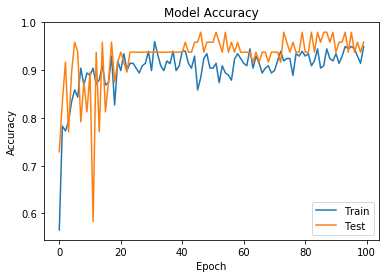

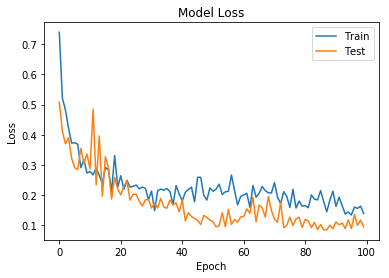

In [62]:
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("*Dense201_Acc_curve.svg")
plt.savefig("*Dense201_Acc_curve.jpeg")
plt.show()

plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("*Dense201_Loss_curve.svg")
plt.savefig("*Dense201_Loss_curve.jpeg")
plt.show()

In [ ]:
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
# plt.savefig("Dense201_Acc_curve.svg")
# plt.savefig("Dense201_Acc_curve.jpeg")
plt.show()

plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
# plt.savefig("Dense201_Loss_curve.svg")
# plt.savefig("Dense201_Loss_curve.jpeg")
plt.show()

In [63]:
import glob
count=0
for i in glob.glob("../working/dataset/generated_three/*"):
    count+=1
print(count)

21314


In [64]:
print("[INFO] evaluating network...")
predIdxs = densenet.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.93      1.00      0.97        28
      normal       1.00      0.92      0.96        26

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



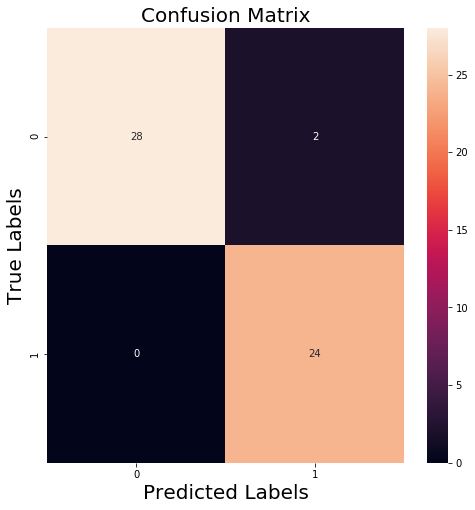

In [65]:
import seaborn as sns 
# plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(8,8))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix',size=20)
plt.savefig("*Dense_Confusion.svg")
plt.savefig("*Dense_Confusion.jpeg")
plt.show()

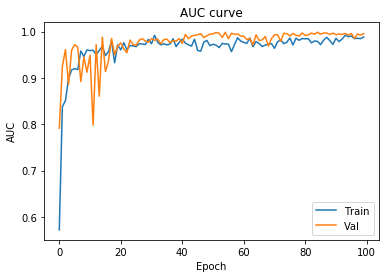

In [66]:
plt.plot(densenet_history.history['auc'])
plt.plot(densenet_history.history['val_auc'])
plt.title("AUC curve")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(['Train','Val'],loc='best')
plt.savefig("*Dense201_Auc_curve.svg")
plt.savefig("*Dense201_Auc_curve.jpeg")
plt.show()

In [67]:
attack_model = KerasModel(densenet,bounds=(0,255))
attack = FGSM(attack_model)

In [ ]:
# densenet.save("densenet_with_random_state_{}.h5".format(random_value))

In [ ]:
# labels=['covid','normal']
# plt.figure(figsize =(40,40))
# for i in range(31):
#     plt.subplot(7,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.title(labels[(np.argmax(testY[i], axis=0))])
#     plt.imshow(testX.reshape(-1,224,224,3)[i])
    
#     if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
#         plt.xlabel(labels[predIdxs[i]],color='blue')
#     else:
#         plt.xlabel(labels[predIdxs[i]],color='red')
# plt.show()

In [ ]:
import tensorflow as tf
i=2
eps=0.02
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(densenet.predict(testX[i].reshape(1,224,224,3)))]
adv_pred_label=labels[np.argmax(densenet.predict(adv_image.reshape(1,224,224,3)))]
print(org_label)
print(adv_pred_label)

In [ ]:
signed_grad

In [ ]:
plt.imshow(signed_grad)

In [ ]:
i=53
eps=.05
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(label[np.argmax(densenet.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(densenet.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=2
eps=0.05
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

org=(label[np.argmax(densenet.predict(testX[i].reshape(1,224,224,3)))])
pred=(label[np.argmax(densenet.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title(f"Actual Label:{org}")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title(f"Predicted Label:{pred}",color='red')
plt.savefig("With_HUMAN_EYE_Dense201.svg")
plt.savefig("With_HUMAN_EYE_Dense201.jpeg")
plt.imshow(adv_image.reshape(224,224,3))
print(org)
print(pred)
print(f"Normal Image Prediction Probability: {np.max(densenet.predict(testX[i].reshape(1,224,224,3)))}")
print(f"Same Label Adversarial Prediction Probability : {np.max(densenet.predict(adv_image.reshape(1,224,224,3)))}")

In [68]:
#prediction probability
import tensorflow as tf
# epsilon=[0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
#          0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
#          0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
#          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
    
# ]
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09]
# epsilon=[0.0003]
for eps in epsilon:
    probability=[]
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(densenet.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_prob = max(max(densenet.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability.append(max_prob)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    try:
        prob_decrease = (sum(probability)/len(probability))*100
    except:
        prob_decrease =0
    final_probability.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.2f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.2f}".format(len(probability),eps,prob_decrease))
    

For epsilon : 0.0001
Numbers of Correct Prediction with Adversarial :  52
Numbers of Wrong Prediction with Adversarial :  2
Accuracy during eps = 0.0001 is 96.30
Probability of total images = 52 during eps = 0.0001 is 92.66
For epsilon : 0.0003
Numbers of Correct Prediction with Adversarial :  51
Numbers of Wrong Prediction with Adversarial :  3
Accuracy during eps = 0.0003 is 94.44
Probability of total images = 51 during eps = 0.0003 is 87.92
For epsilon : 0.0005
Numbers of Correct Prediction with Adversarial :  47
Numbers of Wrong Prediction with Adversarial :  7
Accuracy during eps = 0.0005 is 87.04
Probability of total images = 47 during eps = 0.0005 is 84.04
For epsilon : 0.0007
Numbers of Correct Prediction with Adversarial :  43
Numbers of Wrong Prediction with Adversarial :  11
Accuracy during eps = 0.0007 is 79.63
Probability of total images = 43 during eps = 0.0007 is 78.97
For epsilon : 0.0009
Numbers of Correct Prediction with Adversarial :  35
Numbers of Wrong Prediction w

In [69]:
data_list = {'Epsilon':worked_eps,'Correct Predict':correct_pred,'Wrong Predict':wrong_pred,'Accuracy':accuracy_correct_pred_on_that_eps,'Probability Decrease':final_probability}
adversarial_dataframe_sars= pd.DataFrame(data_list)
adversarial_dataframe_sars.to_excel(r'../working/chest_Dense201_ImageGenerator_withPredictionDecrease.xlsx', sheet_name='ChestXray Dense201', index = False)


# Print the curve of fgsm attack

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [ ]:
x_axis = [0.0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
         0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
          0.01,0.02,0.03
         ]
correct_vgg =[54,52,52,52,52,52,52,52,52,51,
             51,49,40,25,16,12,10,9,9,
              4,2,2
             ]
wrong_vgg=[0,2,2,2,2,2,2,2,2,3,
           3,5,14,29,38,42,44,45,45,
           50,52,52
    
]

In [ ]:
len(x_axis),len(correct_vgg),len(wrong_vgg)

In [ ]:
# plt.figure(figsize =(15,10))
plt.plot(x_axis,correct_vgg,color='blue',label='Number of Correct Prediction')
plt.plot(x_axis,wrong_vgg,color='red',label='Number of Wrong Prediction')
plt.title("Vgg16 Model")
plt.xlabel("Epsilon")
plt.ylabel("Numbers")
plt.legend()
plt.show

In [ ]:
correct_incept = [54,54,54,53,52,52,52,51,51,50,
                  49,39,36,31,31,30,30,30,30,
                  30,30,30
    
]
wrong_incept = [0,0,0,1,2,2,2,3,3,4,
               5,15,18,23,23,24,24,24,24,
                24,24,24
               ]

In [ ]:
len(correct_incept),len(wrong_incept)

# SQUEEZENET

In [ ]:
pip install git+https://github.com/rcmalli/keras-squeezenet.git

In [ ]:
from keras_squeezenet import SqueezeNet

In [ ]:
import h5py
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D


def SqueezeNet(nb_classes, inputs=(3, 224, 224)):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)

    @param nb_classes: total number of final categories

    Arguments:
    inputs -- shape of the input images (channel, cols, rows)

    """

    input_img = Input(shape=inputs)
    conv1 = Convolution2D(
        96, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_first")(input_img)
    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1',
        data_format="channels_first")(conv1)
    fire2_squeeze = Convolution2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_squeeze',
        data_format="channels_first")(maxpool1)
    fire2_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand1',
        data_format="channels_first")(fire2_squeeze)
    fire2_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire2_expand2',
        data_format="channels_first")(fire2_squeeze)
    merge2 = Concatenate(axis=1)([fire2_expand1, fire2_expand2])

    fire3_squeeze = Convolution2D(
        16, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_squeeze',
        data_format="channels_first")(merge2)
    fire3_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand1',
        data_format="channels_first")(fire3_squeeze)
    fire3_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire3_expand2',
        data_format="channels_first")(fire3_squeeze)
    merge3 = Concatenate(axis=1)([fire3_expand1, fire3_expand2])

    fire4_squeeze = Convolution2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_squeeze',
        data_format="channels_first")(merge3)
    fire4_expand1 = Convolution2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand1',
        data_format="channels_first")(fire4_squeeze)
    fire4_expand2 = Convolution2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire4_expand2',
        data_format="channels_first")(fire4_squeeze)
    merge4 = Concatenate(axis=1)([fire4_expand1, fire4_expand2])
    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4',
        data_format="channels_first")(merge4)

    fire5_squeeze = Convolution2D(
        32, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_squeeze',
        data_format="channels_first")(maxpool4)
    fire5_expand1 = Convolution2D(
        128, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand1',
        data_format="channels_first")(fire5_squeeze)
    fire5_expand2 = Convolution2D(
        128, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire5_expand2',
        data_format="channels_first")(fire5_squeeze)
    merge5 = Concatenate(axis=1)([fire5_expand1, fire5_expand2])

    fire6_squeeze = Convolution2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_squeeze',
        data_format="channels_first")(merge5)
    fire6_expand1 = Convolution2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand1',
        data_format="channels_first")(fire6_squeeze)
    fire6_expand2 = Convolution2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire6_expand2',
        data_format="channels_first")(fire6_squeeze)
    merge6 = Concatenate(axis=1)([fire6_expand1, fire6_expand2])

    fire7_squeeze = Convolution2D(
        48, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_squeeze',
        data_format="channels_first")(merge6)
    fire7_expand1 = Convolution2D(
        192, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand1',
        data_format="channels_first")(fire7_squeeze)
    fire7_expand2 = Convolution2D(
        192, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire7_expand2',
        data_format="channels_first")(fire7_squeeze)
    merge7 = Concatenate(axis=1)([fire7_expand1, fire7_expand2])

    fire8_squeeze = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_squeeze',
        data_format="channels_first")(merge7)
    fire8_expand1 = Convolution2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand1',
        data_format="channels_first")(fire8_squeeze)
    fire8_expand2 = Convolution2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire8_expand2',
        data_format="channels_first")(fire8_squeeze)
    merge8 = Concatenate(axis=1)([fire8_expand1, fire8_expand2])

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8',
        data_format="channels_first")(merge8)
    fire9_squeeze = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_squeeze',
        data_format="channels_first")(maxpool8)
    fire9_expand1 = Convolution2D(
        256, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand1',
        data_format="channels_first")(fire9_squeeze)
    fire9_expand2 = Convolution2D(
        256, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name='fire9_expand2',
        data_format="channels_first")(fire9_squeeze)
    merge9 = Concatenate(axis=1)([fire9_expand1, fire9_expand2])

    fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(
        nb_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_first")(fire9_dropout)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_first')(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax)

In [ ]:
model = SqueezeNet(
            2, inputs=(3, 224, 244))

In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

#     if weights == 'imagenet' and classes != 1000:
#         raise ValueError('If using `weights` as imagenet with `include_top`'
#                          ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [ ]:
input_shape = (224, 224, 3)

img_in = Input(input_shape)  
basemodel = SqueezeNet(include_top=False, input_shape=input_shape,input_tensor=img_in,pooling='avg')

In [ ]:
basemodel.summary()

In [ ]:
from keras.layers import AveragePooling2D,Dense,Dropout,Flatten,BatchNormalization
# # baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# # construct the head of the model that will be placed on top of the
# # the base model
# headModel = basemodel.output
# # headModel = Dropout(0.5, name='drop9')(headModel)
# # print(headModel)
# headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
# # headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(64, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(2, activation="softmax")(headModel)
# # place the head FC model on top of the base model (this will become
# # the actual model we will train)
# model = Model(inputs=basemodel.input, outputs=headModel)
# # loop over all layers in the base model and freeze them so they will
# # *not* be updated during the first training process
# for layer in basemodel.layers:
#     layer.trainable = False


# try another
x = basemodel.output 

x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
# x = Dropout(0.5)(x)
predictions = Dense(2, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
# compile our model
print("[INFO] compiling model...")
EPOCHS=100
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=METRICS)
# callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
#              ModelCheckpoint(filepath='Vgg16_best_till_now.h5',monitor='val_loss',save_best_only=True)
#             ]

# train the head of the network
print("[INFO] training head...")
squeeze_hist = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

In [ ]:
plt.plot(squeeze_hist.history['accuracy'])
plt.plot(squeeze_hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("Squeeze_Acc_curve.svg")
plt.savefig("Squeeze_Acc_curve.jpeg")
plt.show()

plt.plot(squeeze_hist.history['loss'])
plt.plot(squeeze_hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.savefig("Squeeze_Loss_curve.svg")
plt.savefig("Squeeze_Loss_curve.jpeg")
plt.show()

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


In [ ]:
import seaborn as sns 
# plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(8,8))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)
plt.savefig("Squeeze_Confusion.svg")
plt.savefig("Squeeze_Confusion.jpeg")
plt.show()

In [ ]:
plt.plot(squeeze_hist.history['auc'])
plt.plot(squeeze_hist.history['val_auc'])
plt.title("AUC curve")
plt.ylabel("AUC")
plt.xlabel("Epoch")
plt.legend(['Train','Val'],loc='best')
plt.savefig("Squeeze_Auc_curve.svg")
plt.savefig("Squeeze_Auc_curve.jpeg")
plt.show()

# FGSM

In [ ]:
attack_model = KerasModel(model,bounds=(0,255))
attack = FGSM(attack_model)

In [ ]:
i=30
eps=0.05
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

org=(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
pred=(label[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title(f"Actual Label:{org}")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title(f"Predicted Label:{pred}",color='red')
# plt.savefig("With_HUMAN_EYE_Dense201.svg")
# plt.savefig("With_HUMAN_EYE_Dense201.jpeg")
plt.imshow(adv_image.reshape(224,224,3))
print(org)
print(pred)
print(f"Normal Image Prediction Probability: {np.max(model.predict(testX[i].reshape(1,224,224,3)))}")
print(f"Same Label Adversarial Prediction Probability : {np.max(model.predict(adv_image.reshape(1,224,224,3)))}")

In [ ]:
signed_grad

In [ ]:
#prediction probability
import tensorflow as tf
# epsilon=[0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
#          0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
#          0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
#          0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
    
# ]
worked_eps=[]
correct_pred=[]
wrong_pred=[]
accuracy_correct_pred_on_that_eps=[]
total_n = len(testX)
final_probability=[]
epsilon=[ 0.0001,0.0003,0.0005,0.0007,0.0009,0.001,0.003,0.005,0.007,0.009,0.01,0.03,0.05,0.07,0.09]
# epsilon=[0.0003]
for eps in epsilon:
    probability=[]
    count_adv=0
    vhul_count_adv=0
    for k in range(total_n):
        grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
        signed_grad = tf.sign(grad)
        adversarial_image = testX[k]+(signed_grad*eps)
        adv_image = adversarial_image.numpy()
        orginal_pred = np.argmax(testY[k])
        adv_pred = np.argmax(densenet.predict(adv_image.reshape(1,224,224,3)))
        if(orginal_pred == adv_pred):
            count_adv=count_adv+1
            max_prob = max(max(densenet.predict(adv_image.reshape(1,224,224,3))))
#             print(max_prob)
            probability.append(max_prob)
            
#             print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
        else:
            vhul_count_adv=vhul_count_adv+1
#             print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    worked_eps.append(eps)
    correct_pred.append(count_adv)
    wrong_pred.append(vhul_count_adv)
    acc = (count_adv/total_n)*100
    accuracy_correct_pred_on_that_eps.append(acc)
    try:
        prob_decrease = (sum(probability)/len(probability))*100
    except:
        prob_decrease =0
    final_probability.append(prob_decrease)
    print("For epsilon : {}".format(eps))
    print("Numbers of Correct Prediction with Adversarial : ",count_adv)
    print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
    print("Accuracy during eps = {} is {:.4f}".format(eps,acc))
    print("Probability of total images = {} during eps = {} is {:.4f}".format(len(probability),eps,prob_decrease))
    

In [ ]:
model.summary()